In [ ]:
import pandas as pd
import numpy as np

# Đọc dữ liệu
df_train = pd.read_csv('/content/df_train_clean.csv')
df_dev   = pd.read_csv('/content/df_dev_clean.csv')
df_test  = pd.read_csv('/content/df_test_clean.csv')

# Định nghĩa nhãn
emotions = ['Enjoyment', 'Disgust', 'Sadness', 'Anger', 'Fear', 'Surprise', 'Other']
label2id = {e: i for i, e in enumerate(emotions)}
id2label = {i: e for i, e in enumerate(emotions)}

In [ ]:
for df in (df_train, df_dev, df_test):
    if 'label_id' not in df:
        if 'Emotion' in df:
            df['label_id'] = df['Emotion'].map(label2id)
        elif 'label' in df:
            df['label_id'] = df['label'].map(label2id)
    df['content_clean'] = df['content_clean'].fillna('').astype(str)

In [ ]:
X_train = df_train['content_clean'].tolist()
y_train = df_train['label_id'].astype(int).to_numpy()
X_dev   = df_dev['content_clean'].tolist()
y_dev   = df_dev['label_id'].astype(int).to_numpy()
X_test  = df_test['content_clean'].tolist()
y_test  = df_test['label_id'].astype(int).to_numpy()
num_classes = len(emotions)

In [ ]:
df_train

,Unnamed: 0,Emotion,content,content_clean,label_id
0,188,Other,cho mình xin bài nhạc tên là gì với ạ,cho mình xin bài nhạc tên là gì với ạ,6
1,166,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,1
2,1345,Disgust,lo học đi . yêu đương lol gì hay lại thích học...,lo học đi . yêu đương lồn gì hay lại thích học...,1
3,316,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :)),uớc gì sau này về già vẫn có thể như cụ này ☺️,0
4,1225,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...,mỗi lần có video của con là cứ coi đi coi lại ...,0
...,...,...,...,...,...
5543,1332,Disgust,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...,1
5544,825,Other,nhìn mặt héo queo luôn,nhìn mặt héo queo luôn,6
5545,165,Other,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...,6
5546,363,Enjoyment,thích thân hình boss rồi nhan 😌,thích thân hình boss rồi nhan 😌,0


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

max_seq_len = 80
X_train_ids = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_seq_len, padding='post')
X_dev_ids   = pad_sequences(tokenizer.texts_to_sequences(X_dev),   maxlen=max_seq_len, padding='post')
X_test_ids  = pad_sequences(tokenizer.texts_to_sequences(X_test),  maxlen=max_seq_len, padding='post')

y_train_cat = to_categorical(y_train, num_classes)
y_dev_cat   = to_categorical(y_dev, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Đọc file VnEmoLex.xlsx
emolex = pd.read_excel('/content/VnEmoLex.xlsx')
main_emotions = [
    'Anger\n/ tức giận',
    'Disgust\n/ chán ghét',
    'Fear\n/ sợ hãi',
    'Joy\n/ thích thú',
    'Sadness\n/ buồn bã',
    'Surprise\n/ ngạc nhiên'
]
word_col = 'Vietnamese'

emolex_dict = {}
for _, row in emolex.iterrows():
    word = str(row[word_col]).strip().lower()
    vector = []
    for col in main_emotions:
        try:
            value = float(row[col])
        except:
            value = 0.0
        vector.append(value)
    emolex_dict[word] = np.array(vector, dtype=float)

import re
def vn_emolex_features(text):
    words = re.findall(r'\w+', str(text).lower())
    emotion_vec = np.zeros(len(main_emotions))
    for w in words:
        if w in emolex_dict:
            emotion_vec += emolex_dict[w]
    return emotion_vec

def batch_vn_emolex_features(series):
    return np.vstack([vn_emolex_features(s) for s in series])

train_emolex = batch_vn_emolex_features(df_train['content_clean'])
dev_emolex   = batch_vn_emolex_features(df_dev['content_clean'])
test_emolex  = batch_vn_emolex_features(df_test['content_clean'])


In [ ]:
emoji2word_df = pd.read_excel('/content/emoji2word.xlsx')  # file bạn đã từng upload
emoji2word_dict = {row['emoji']: str(row['word_vn']).strip().lower() for _, row in emoji2word_df.iterrows()}

def replace_emojis_with_words(text):
    # Thay emoji bằng từ tương ứng, nếu có trong emoji2word_dict
    out = []
    for c in text:
        if c in emoji2word_dict:
            out.append(emoji2word_dict[c])
        else:
            out.append(c)
    return ''.join(out)

def vn_emolex_emoji_features(text):
    # Đặc trưng VnEmoLex sau khi đã thay emoji bằng từ
    text2 = replace_emojis_with_words(text)
    return vn_emolex_features(text2)

def batch_vn_emolex_emoji_features(series):
    return np.vstack([vn_emolex_emoji_features(s) for s in series])

train_emoji = batch_vn_emolex_emoji_features(df_train['content_clean'])
dev_emoji   = batch_vn_emolex_emoji_features(df_dev['content_clean'])
test_emoji  = batch_vn_emolex_emoji_features(df_test['content_clean'])


In [ ]:
# Gộp đặc trưng VnEmoLex và emoji2word lại
train_features = np.concatenate([train_emolex, train_emoji], axis=1)
dev_features   = np.concatenate([dev_emolex,   dev_emoji],   axis=1)
test_features  = np.concatenate([test_emolex,  test_emoji],  axis=1)
emotion_dim = train_features.shape[1]  # Số chiều: 12

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, MaxPooling1D, Dense, Dropout, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.models import Model

embedding_dim = 100

# Nhánh văn bản
inp = Input(shape=(max_seq_len,), name='input_text')
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len)(inp)
x = Bidirectional(GRU(64, return_sequences=True, dropout=0.2))(x)
x = MaxPooling1D(pool_size=2)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.2)(x)

# Nhánh đặc trưng cảm xúc
inp_feat = Input(shape=(emotion_dim,), name='input_features')
f = Dense(24, activation='relu')(inp_feat)
f = Dropout(0.2)(f)

# Gộp
concat = Concatenate()([x, f])
out = Dense(num_classes, activation='softmax')(concat)

model = Model(inputs=[inp, inp_feat], outputs=out)
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_text          │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 80, 100)   │    426,600 │ input_text[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 80, 128)   │     63,744 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 40, 128)   │          0 │ bidirectional[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ max_pooling1d[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_features      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 50)        │      6,450 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 24)        │        312 │ input_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 74)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7)         │        525 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 497,631 (1.90 MB)

 Trainable params: 497,631 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    [X_train_ids, train_features], y_train_cat,
    validation_data=([X_dev_ids, dev_features], y_dev_cat),
    batch_size=32,
    epochs=10,
    verbose=1
)

Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 30s 127ms/step - accuracy: 0.2404 - loss: 1.8533 - val_accuracy: 0.4315 - val_loss: 1.5466
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 41s 125ms/step - accuracy: 0.4800 - loss: 1.4159 - val_accuracy: 0.5423 - val_loss: 1.2028
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 43s 136ms/step - accuracy: 0.6636 - loss: 0.9718 - val_accuracy: 0.5554 - val_loss: 1.1802
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 39s 127ms/step - accuracy: 0.7557 - loss: 0.7289 - val_accuracy: 0.5496 - val_loss: 1.2485
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - accuracy: 0.8363 - loss: 0.5021 - val_accuracy: 0.5641 - val_loss: 1.3300
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 42s 127ms/step - accuracy: 0.8763 - loss: 0.3884 - val_accuracy: 0.5539 - val_loss: 1.5404
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - accuracy: 0.9111 - loss: 0.2867 - val_accuracy: 0.5539 - val_loss: 1.6799
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - accuracy: 0.9203 - loss: 0

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
              precision    recall  f1-score   support

   Enjoyment     0.6650    0.6891    0.6768       193
     Disgust     0.5130    0.4470    0.4777       132
     Sadness     0.6186    0.6293    0.6239       116
       Anger     0.3400    0.4250    0.3778        40
        Fear     0.6122    0.6522    0.6316        46
    Surprise     0.4412    0.4054    0.4225        37
       Other     0.4646    0.4574    0.4609       129

    accuracy                         0.5570       693
   macro avg     0.5221    0.5293    0.5245       693
weighted avg     0.5568    0.5570    0.5560       693



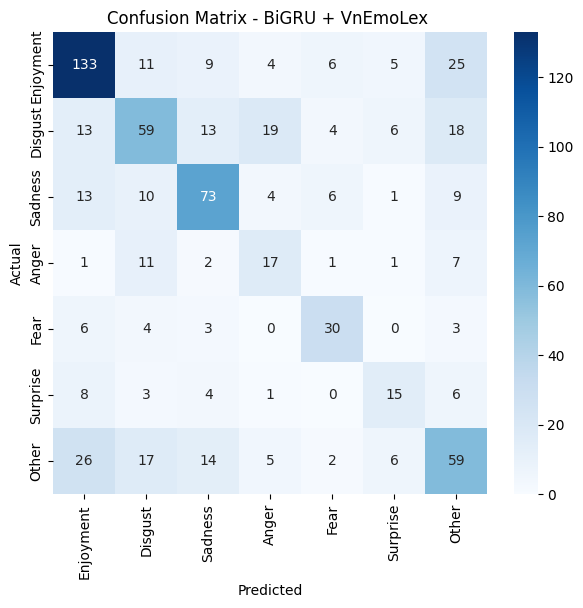

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict([X_test_ids, test_features], batch_size=32)
y_pred_cls = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_cls, target_names=emotions, digits=4))
cm = confusion_matrix(y_test, y_pred_cls)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - BiGRU + VnEmoLex ")
plt.show()
